In [1]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime

from src.utils.model_runner import evaluate_models, plot_roc_curves, plot_precision_recall_curves, plot_classification_metric
from src.utils.preprocess import GeneExpPreprocessor
from src.utils.data_handler import DataHandler
from sklearn.feature_selection import SelectKBest, f_classif

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [3]:
df_latent = pd.read_csv('data/raw/latent_space_5dim_all_samples.csv', index_col=[0,1])

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
pfs = metadata['Progress Free Survival (Months)']

n_patients = df_latent.index.get_level_values("patient_id").nunique()
n_samples = df_latent.index.get_level_values("sample_id").nunique()
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

There are 1018 patients and 1132 samples in the dataset.


<h1>Align indices for df_exp and PFS</h2>

In [4]:
df = df_latent.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df.index.set_levels(
    df.index.levels[1].map(truncate_sample_id),
    level=1
)

df.index = new_index

<h1>Generate X and y</h1>

In [5]:
X = df.copy()

# remove samples with nan pfs values
pfs = pfs.dropna()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(pfs.index)
print(f"Number of samples in intersection: {len(intersection_samples)}")

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
pfs = pfs.loc[intersection_samples]

# get bool of whether pfs is greater than 5 years
y = pfs > 5 * 12 
y = list(y)

Number of samples in intersection: 1006


In [9]:
X.describe()

,latent_0,latent_1,latent_2,latent_3,latent_4
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,0.479890,-0.484980,0.060386,-0.528110,-0.190463
std,3.136470,2.302389,1.869032,2.354432,2.050703
min,-9.664533,-9.662246,-6.045005,-14.875936,-9.127463
25%,-1.097720,-1.614682,-0.898258,-1.371248,-1.130695
50%,-0.152589,-0.285715,-0.007015,-0.007214,0.017061
75%,1.202129,0.692039,0.953019,0.818767,0.933700
max,11.128418,9.510510,8.405281,5.509240,8.654226


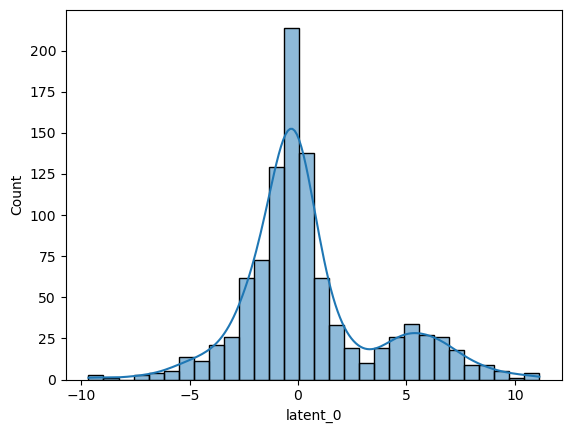

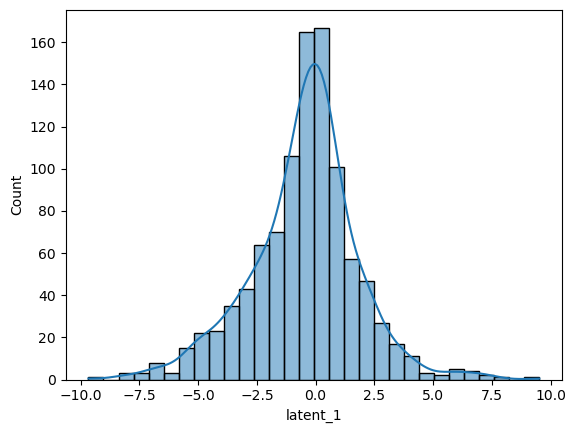

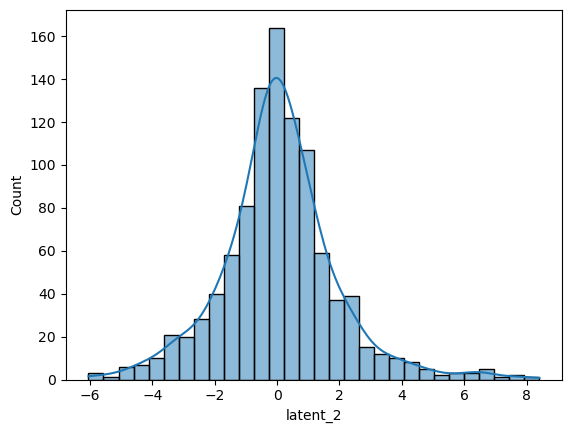

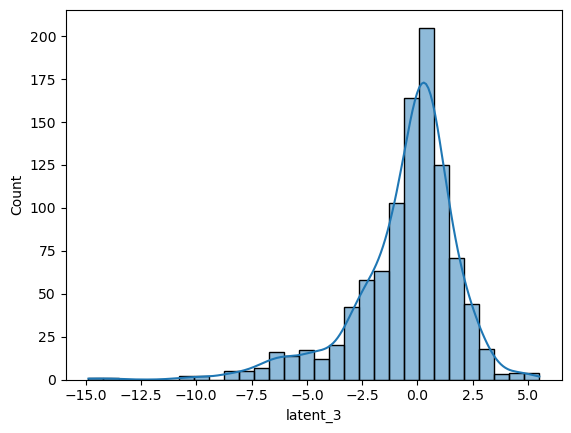

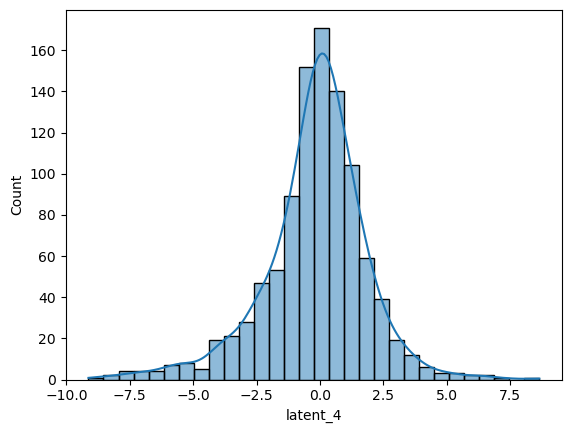

In [8]:
for col in X.columns:
    sns.histplot(X.loc[:,col], bins=30, kde=True)
    plt.show()

Text(0.5, 1.0, 'PFS > 5 years')

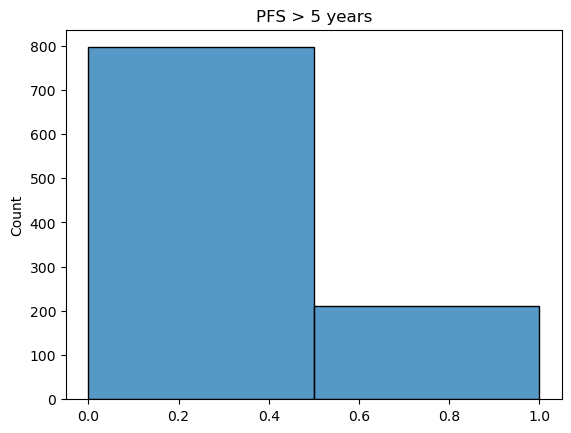

In [10]:
ax = sns.histplot(y, bins=2)
ax.set_title('PFS > 5 years')

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [11]:
def training_fold_filtering(X: pd.DataFrame, y: np.ndarray, k: int) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Example filtering:
    1. Filter by mean expression
    2. Filter by variance
    3. Filter by within-class variance
    5. Select top k features using SelectKBest
    """
    X = DH.filter_genes_by_within_class_variance(X, y)

    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

In [12]:
# evaluate models with different number of features
results = {}
for k in range(1, 6):
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models(X, y, filter_data=training_fold_filtering, k=k)

Evaluating models with top 1 features...
Evaluating models with top 2 features...
Evaluating models with top 3 features...
Evaluating models with top 4 features...
Evaluating models with top 5 features...


In [13]:
# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(f1_scores)[-3:][::-1]]

<h1>plot data</h1>

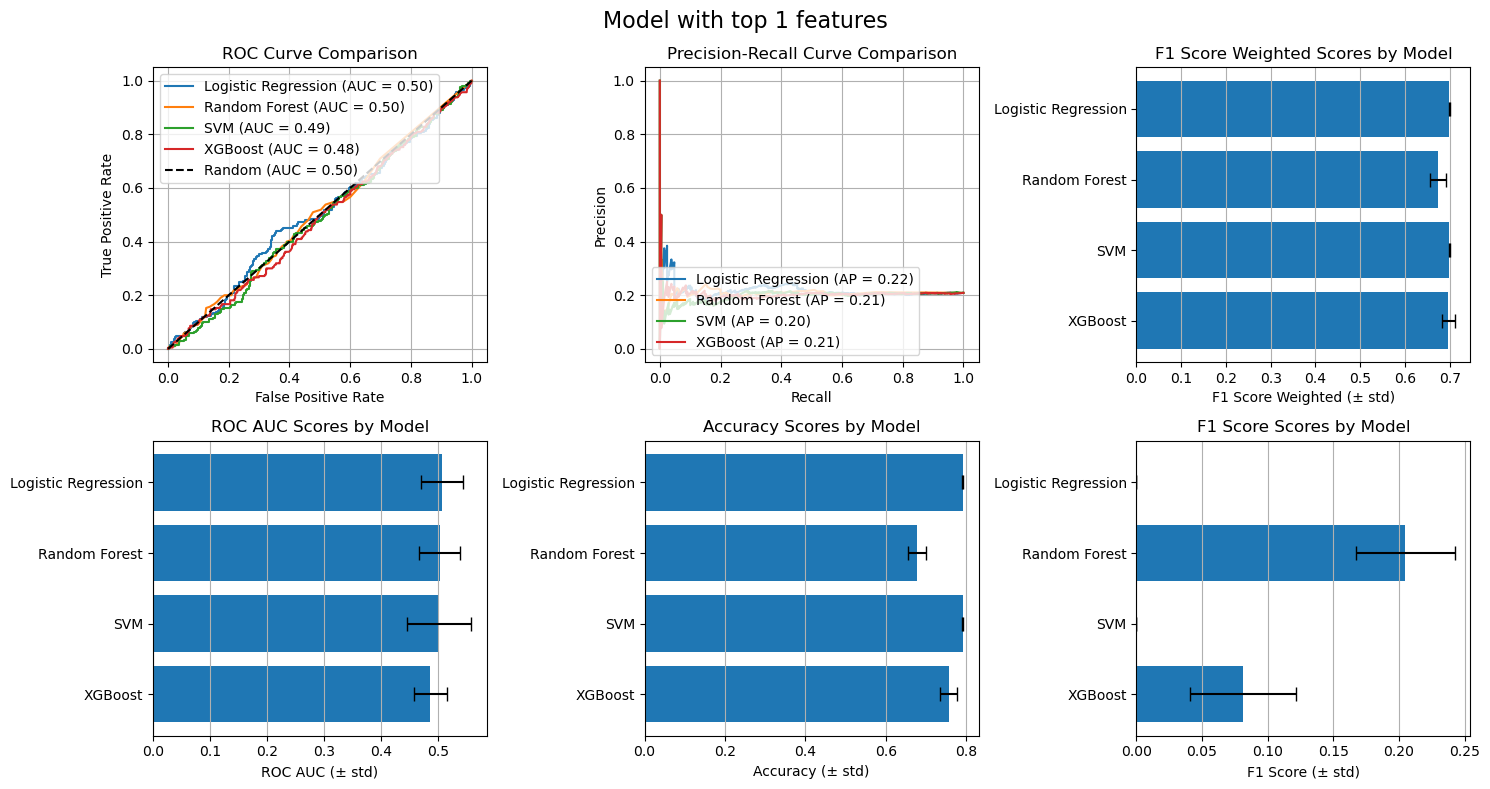

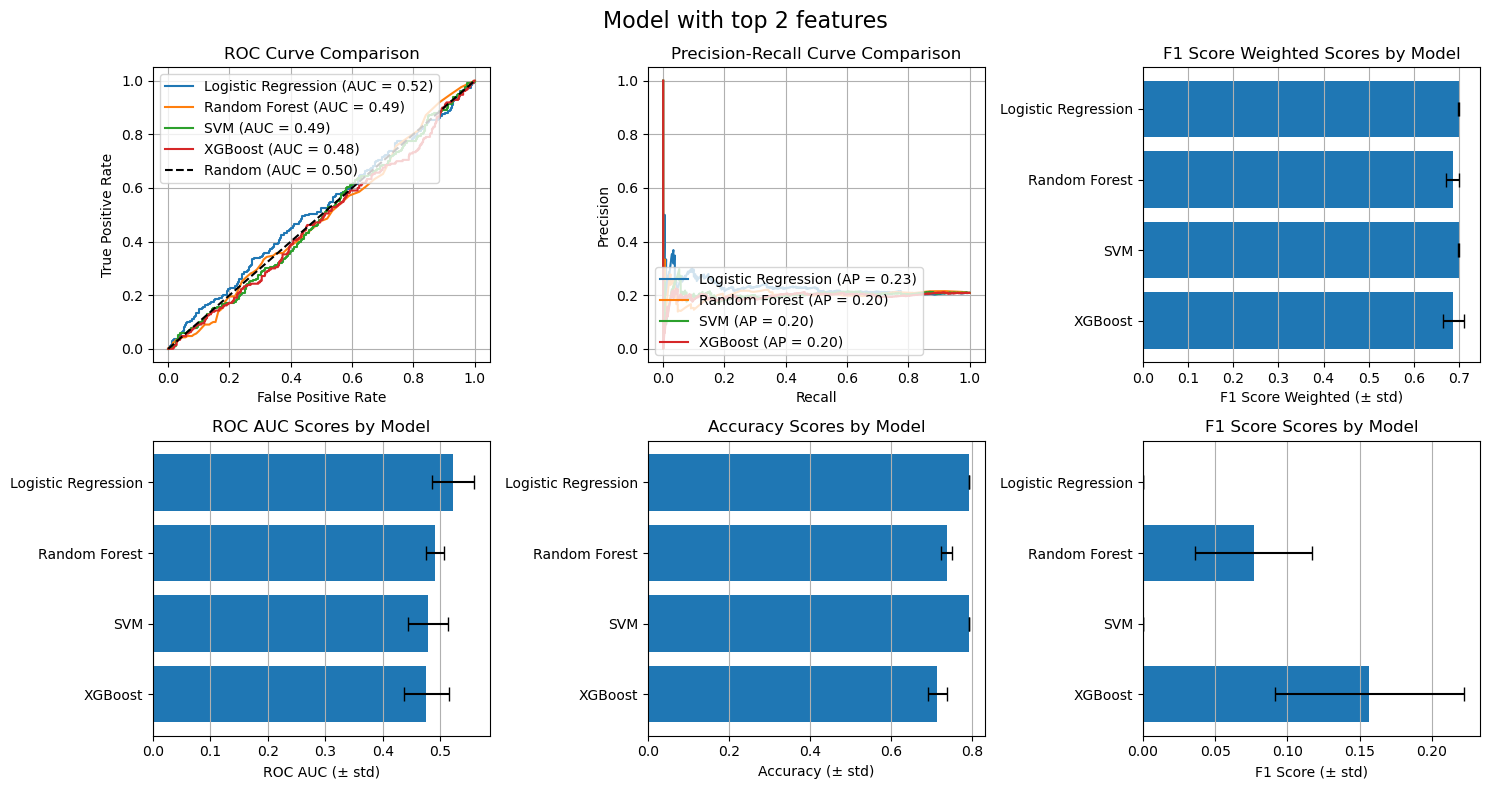

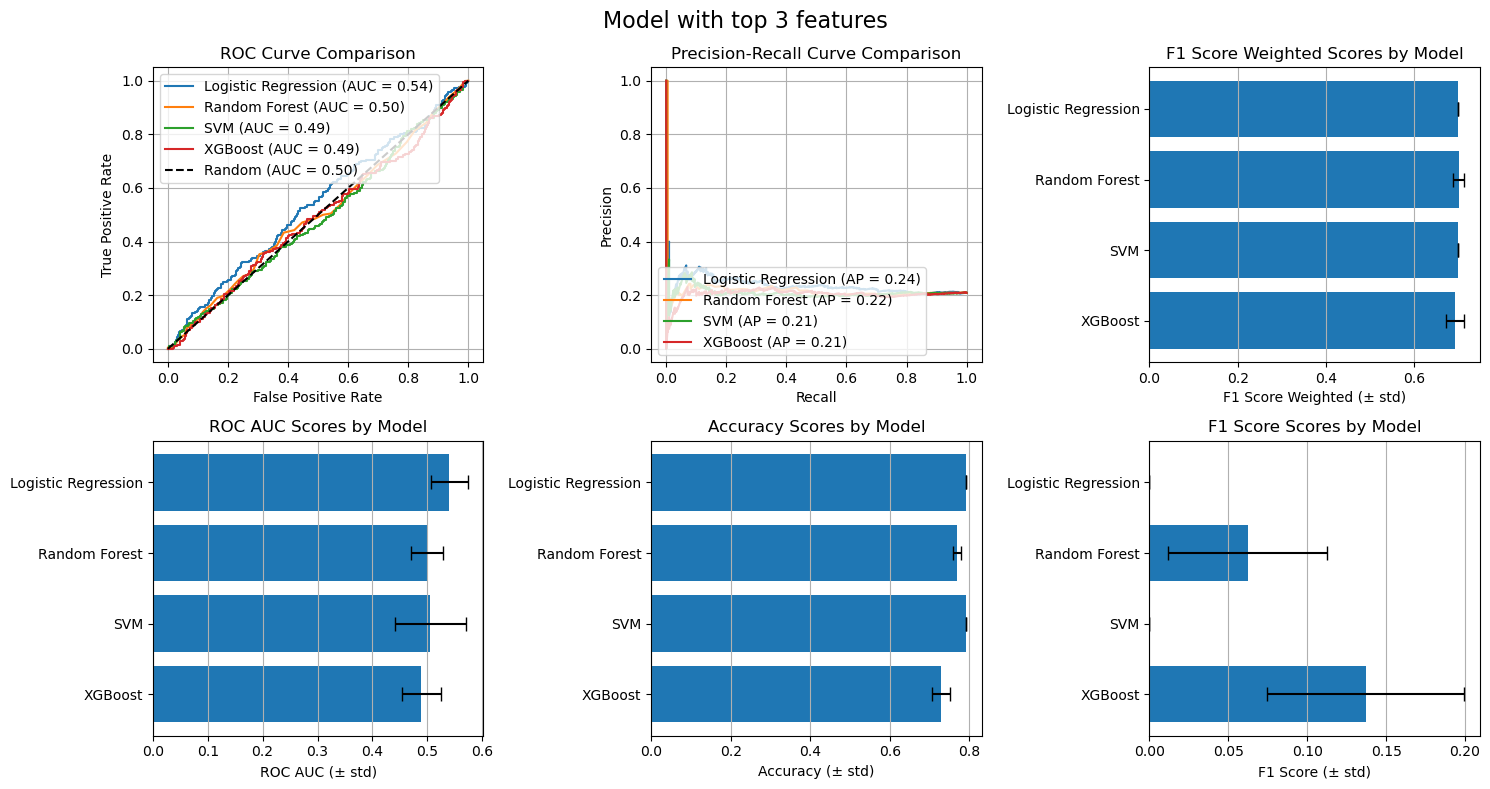

In [14]:
for k in top_k:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='F1 Score')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

<h1>Save results</h1>

In [31]:
timestamp = datetime.datetime.now().strftime("%m%d_%H-%M")
print(f"Timestamp: {timestamp}")

output=f'results/cv_results/gene_expression_{timestamp}.pkl'

os.makedirs("results/cv_results", exist_ok=True)
with open(output, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {output}")

Timestamp: 0606_16-16
Results saved to results/cv_results/gene_expression_0606_16-16.pkl
